# Classificação de Estágios da Doença de Alzheimer

## SVM

### Bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import random
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss, cohen_kappa_score, hamming_loss, jaccard_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

### Variáveis iniciais

In [2]:
# Valor fixo de seed para reprodutibilidade
random_seed = 42

# Pasta do dataset
dataset_folder = "../data/Alzheimer_MRI_4_classes_dataset"
folders = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Número máximo de imagens a serem carregadas
max_images_per_class = 100

### Funções Auxiliares

In [3]:
# Função para avaliar o modelo com múltiplas métricas
def evaluate_model(y_test, y_pred, y_pred_proba):
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(label_binarize(y_test, classes=np.arange(len(folders))), y_pred_proba, multi_class='ovr'),
        'Log Loss': log_loss(y_test, y_pred_proba),
        'Cohen\'s Kappa': cohen_kappa_score(y_test, y_pred),
        'Hamming Loss': hamming_loss(y_test, y_pred),
        'Jaccard Index': jaccard_score(y_test, y_pred, average='macro'),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }
    return metrics

### Random Seed

In [4]:
random.seed(random_seed)
np.random.seed(random_seed)

### Carregar dados

In [5]:
# Função para carregar e pré-processar as imagens
def load_images(dataset_folder, folders, image_size=(128, 128), max_images_per_class=100):
    images = []
    labels = []
    for folder in folders:
        folder_path = os.path.join(dataset_folder, folder)
        if os.path.exists(folder_path):
            count = 0
            for img_name in os.listdir(folder_path):
                if count >= max_images_per_class:
                    break
                img_path = os.path.join(folder_path, img_name)
                image = Image.open(img_path).convert("RGB")
                image = image.resize(image_size)
                images.append(np.array(image).flatten())  # Flatten the image
                labels.append(folder)
                count += 1
    return np.array(images), np.array(labels)

In [6]:
# Carregar as imagens e os rótulos
X, y = load_images(dataset_folder, folders, max_images_per_class=max_images_per_class)

In [7]:
# Codificar os rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

### Dividir em treino e teste

In [8]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=random_seed)

In [9]:
# Tamanho do conjunto de treinamento
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Tamanho do conjunto de teste
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (291, 49152)
y_train shape: (291,)
X_test shape: (73, 49152)
y_test shape: (73,)


## Funcionamento do Modelo com Parâmetros Padrão

### Treinar o modelo

In [10]:
model = RandomForestClassifier(random_state=random_seed)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Predizer utilizando o modelo treinado

In [11]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

### Métricas

In [12]:
evaluate_model(y_test, y_pred, y_pred_proba)

{'Accuracy': 0.6164383561643836,
 'AUC': np.float64(0.8496227783041893),
 'Log Loss': 0.939330845840283,
 "Cohen's Kappa": np.float64(0.47857142857142854),
 'Hamming Loss': 0.3835616438356164,
 'Jaccard Index': np.float64(0.5423719958202717),
 'MCC': np.float64(0.4911146216515082)}

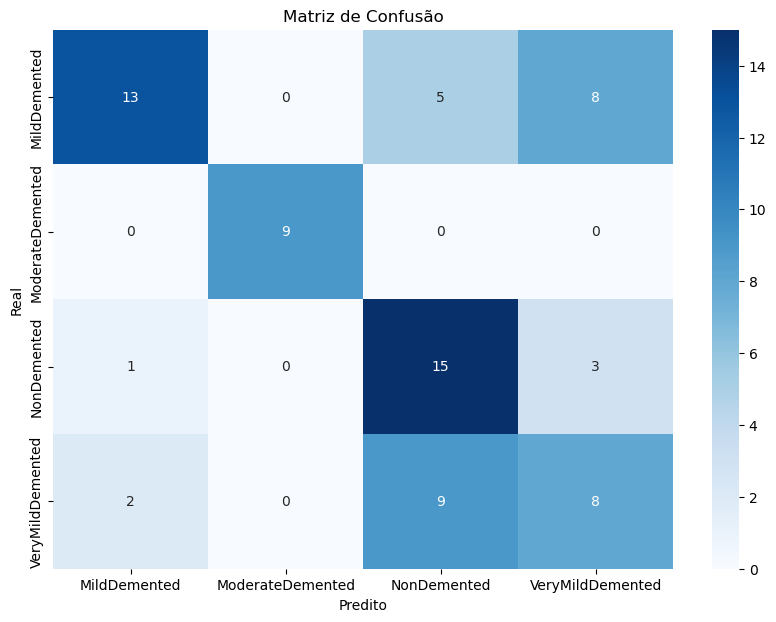

In [13]:
# Matriz de confusão
# É uma ferramenta visual que mostra o desempenho do modelo em cada classe

cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão usando Seaborn com a paleta Set2
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Fine Tuning dos Parâmetros

In [14]:
# Parâmetros para testar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid = ParameterGrid(param_grid)

In [15]:
results = []

for params in grid:
    print(f"Testando parâmetros: {params}")
    model = RandomForestClassifier(**params, random_state=random_seed)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    metrics = evaluate_model(y_test, y_pred, y_pred_proba)
    metrics['Params'] = str(params)
    results.append(metrics)

Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Testando parâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Testando parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Testando parâmetros: {'max_depth': 20

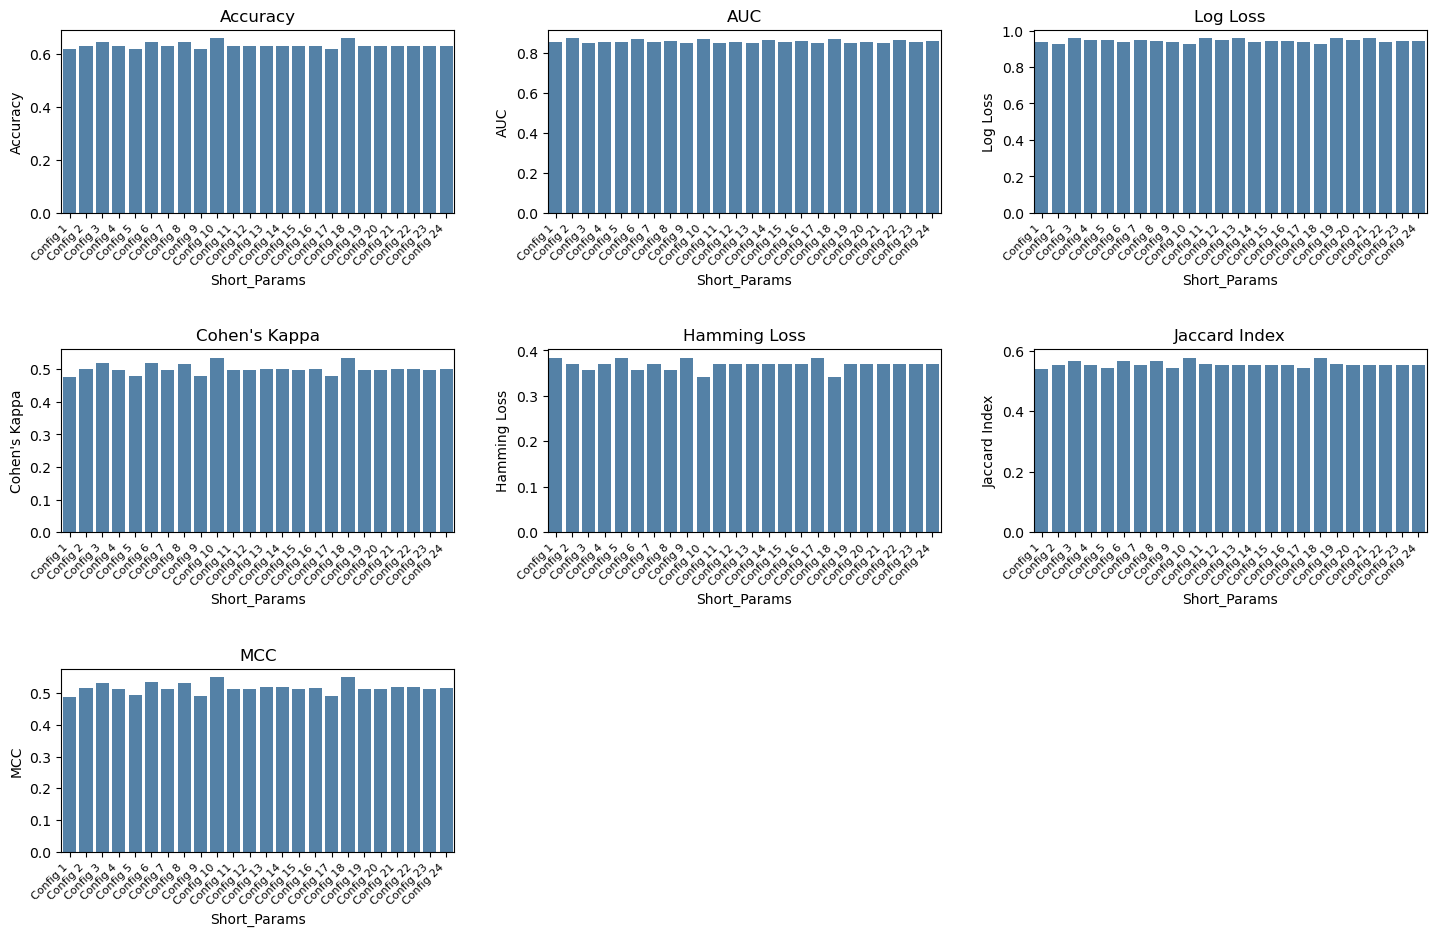

   Short_Params                                             Params
0      Config 1  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...
1      Config 2  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...
2      Config 3  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...
3      Config 4  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...
4      Config 5  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...
5      Config 6  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...
6      Config 7  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...
7      Config 8  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...
8      Config 9  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...
9     Config 10  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...
10    Config 11  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...
11    Config 12  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...
12    Config 13  {'max_depth': 20, 'min_samples_leaf': 2, 'min_...
13    Config 14  {'max_depth': 20, 'min_samples_leaf': 2, 'min

In [16]:
results_df = pd.DataFrame(results)

metrics = ['Accuracy', 'AUC', 'Log Loss', 'Cohen\'s Kappa', 'Hamming Loss', 'Jaccard Index', 'MCC']

# Labels para as configurações de parâmetros para o gráfico
results_df['Short_Params'] = [f'Config {i+1}' for i in range(len(results_df))]

plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.barplot(data=results_df, x='Short_Params', y=metric, color='steelblue')
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.title(metric)
    plt.tight_layout(pad=3.0)

plt.show()
print(results_df[['Short_Params', 'Params']])


### Resultados do Melhor Modelo

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


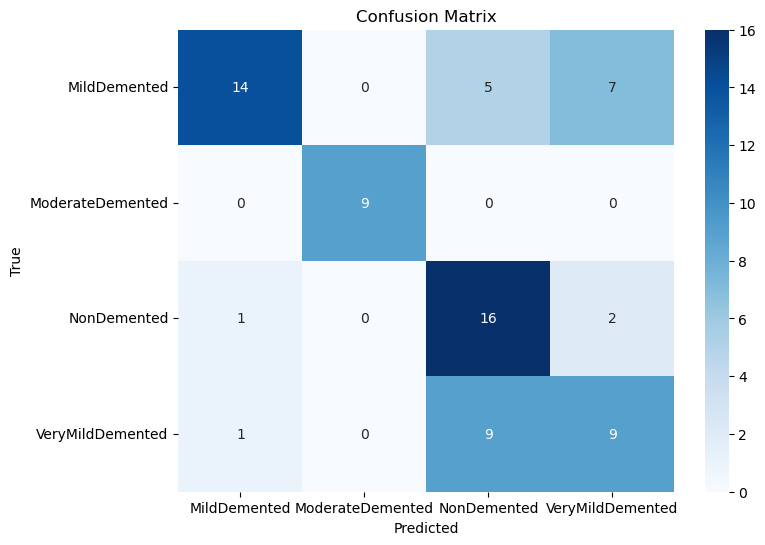

In [17]:
best_model_idx = results_df['Accuracy'].idxmax()  # Baseado na melhor acurácia
best_params = eval(results_df.loc[best_model_idx, 'Params'])
print(best_params)

best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
evaluate_model(y_test, y_pred, y_pred_proba)

{'Accuracy': 0.6575342465753424,
 'AUC': np.float64(0.8694296092112441),
 'Log Loss': 0.9262847089427143,
 "Cohen's Kappa": np.float64(0.534438775510204),
 'Hamming Loss': 0.3424657534246575,
 'Jaccard Index': np.float64(0.5765692640692641),
 'MCC': np.float64(0.5500449927327634)}